<a href="https://colab.research.google.com/github/razim-manzoor/handwritten-digits-cnn/blob/main/HandwrittenDigitsCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import joblib
import json
import pandas as pd

In [2]:
# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
# Normalize pixel values to [0, 1] and reshape for CNN input
def preprocess(images):
    images = images / 255.0
    return images.reshape(-1, 28, 28, 1)

['preprocess.pkl']

In [4]:
train_images = preprocess(train_images)
test_images = preprocess(test_images)

In [5]:
# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [24]:
# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(train_images)

['data_augmentation.pkl']

In [7]:
# Build CNN model
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])
    return model

In [8]:
model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Callbacks
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [11]:
# Train the model
history = model.fit(datagen.flow(train_images, train_labels, batch_size=128),
                    epochs=100,
                    validation_data=(test_images, test_labels),
                    callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 389s 816ms/step - accuracy: 0.8070 - loss: 0.6387 - val_accuracy: 0.8942 - val_loss: 0.3118 - learning_rate: 0.0010
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 336s 716ms/step - accuracy: 0.9690 - loss: 0.1031 - val_accuracy: 0.9910 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 347s 740ms/step - accuracy: 0.9776 - loss: 0.0733 - val_accuracy: 0.9925 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 377s 729ms/step - accuracy: 0.9802 - loss: 0.0642 - val_accuracy: 0.9918 - val_loss: 0.0236 - learning_rate: 0.0010
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 332s 708ms/step - accuracy: 0.9825 - loss: 0.0570 - val_accuracy: 0.9847 - val_loss: 0.0504 - learning_rate: 0.0010
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 338s 721ms/step - accuracy: 0.9838 - loss: 0.0532 - val_accuracy: 0.9913 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 339s 722ms/step -

In [12]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f'\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')


Test accuracy: 0.9956, Test loss: 0.0116


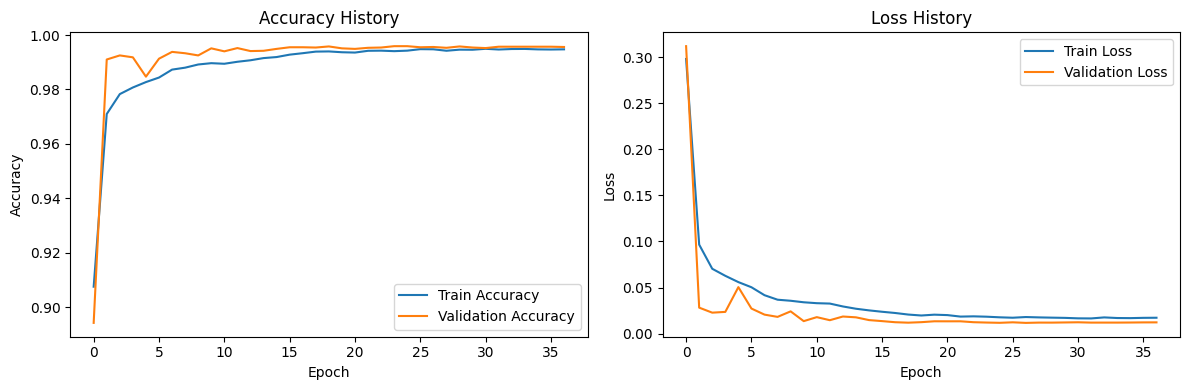

<Figure size 640x480 with 0 Axes>

In [44]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)
plt.savefig('training_history.png')

In [13]:
# Generate predictions
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step


In [14]:
# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      1.00      1.00       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



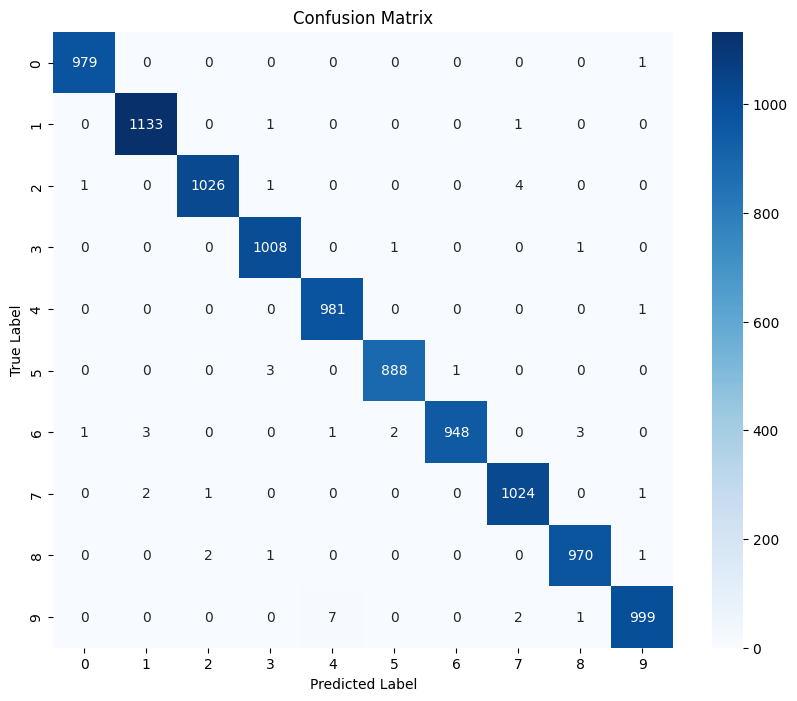

<Figure size 640x480 with 0 Axes>

In [45]:
# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.savefig('confusion_matrix.png')

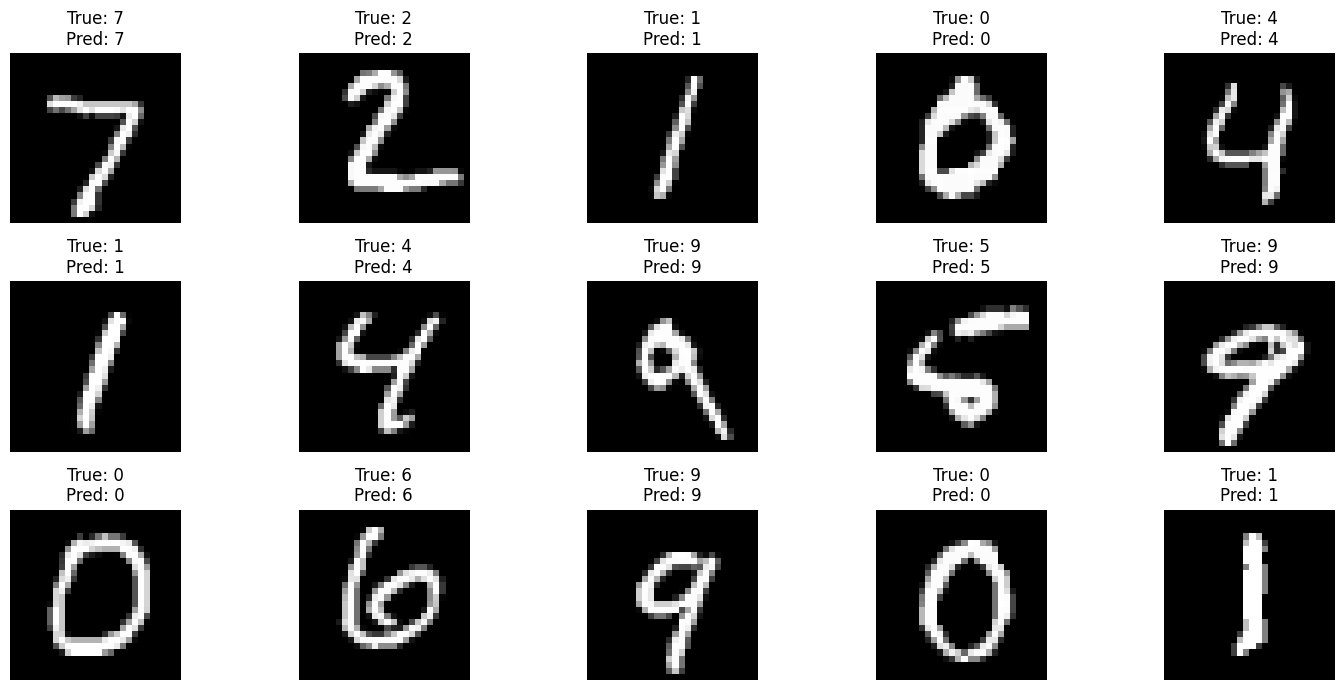

<Figure size 640x480 with 0 Axes>

In [27]:
# Visualize sample predictions
plt.figure(figsize=(15,7))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap='gray')
    plt.title(f'True: {y_true[i]}\nPred: {y_pred_classes[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig('sample_predictions.png')

## Saves

### Model Files

In [18]:
# save model
model.save('mnistModel.h5')

In [30]:
# Architecture
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
  json_file.write(model_json)

In [31]:
# Weights
model.save_weights('model.weights.h5')

### Preprocessing Utilities

In [32]:
# Preprocess Functions
joblib.dump(preprocess, 'preprocess.pkl')

['preprocess.pkl']

In [33]:
# Augementation Pipeline
joblib.dump(datagen, 'data_augmentation.pkl')

['data_augmentation.pkl']

### Evaluation Metrics

In [36]:
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

In [39]:
cm = confusion_matrix(y_true, y_pred_classes)
pd.DataFrame(cm).to_csv('confusion_matrix.csv')

In [40]:
report = classification_report(y_true, y_pred_classes, output_dict=True)
pd.DataFrame(report).transpose().to_csv('classification_report.csv')

In [20]:
!pip freeze > requirements.txt